<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Time_series/Arima/AirPassengersTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Passengers Time Series

## Import libs

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

In [2]:
%matplotlib inline

## Download dataset

In [16]:
%%capture
! wget https://raw.githubusercontent.com/Dimildizio/DS_course/main/Time_series/Arima/AirPassengers.csv

## First view of data

In [36]:
data = pd.read_csv('AirPassengers.csv')

In [29]:
data.columns

Index(['Month', '#Passengers'], dtype='object')

In [30]:
data.shape

(144, 2)

In [31]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [17]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
#Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


<Axes: >

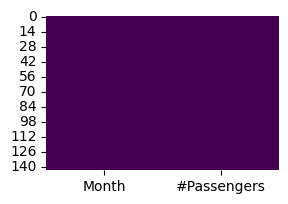

In [26]:
plt.figure(figsize=(3,2))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')

## Perform some transformations

In [121]:
df = data.copy()
df.index = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df = df.rename(columns={'#Passengers':'Passengers'})
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [122]:
monthmin = df.index.min()
monthmax = df.index.max()
display(monthmin)
display(monthmax)

Timestamp('1949-01-01 00:00:00')

Timestamp('1960-12-01 00:00:00')

In [123]:
df.resample('M').sum().tail()

,Passengers
Month,
1960-08-31,606
1960-09-30,508
1960-10-31,461
1960-11-30,390
1960-12-31,432


Emm we don't really need to explicitly set freq=M as of now.
Don't really want to convert 1960-12-01 to 1960-12-31 since we don't know the day colud be the last could be the first. After all we converted form YYYY-MM string format.
Anyways there should be any values but 1 for days.

In [124]:
any(timestamp.day != 1 for timestamp in df.index)

False

### Plot the time series

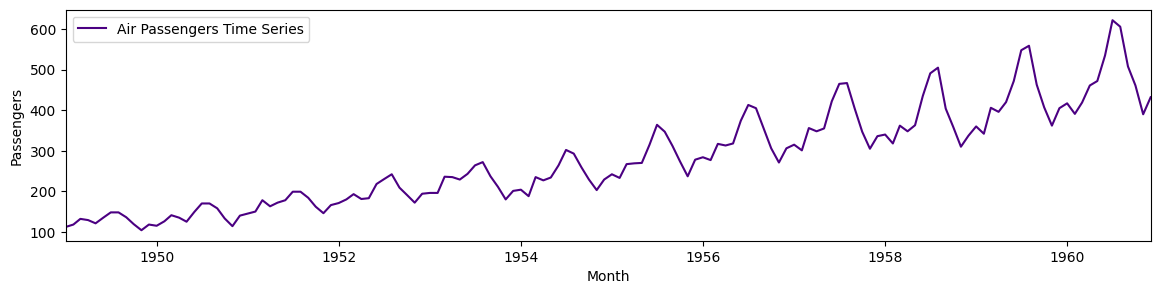

In [126]:
plt.figure(figsize=(14,3))
sns.lineplot(data=df, x=df.index, y='Passengers', label='Air Passengers Time Series', color='indigo')
plt.xlim(df.index.min(), df.index.max())
plt.show()

Peak grow higher and wider. **Multiplicative** model

## Decompose

In [127]:
decomp = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative', period=12)

### Trend

<Axes: xlabel='Month'>

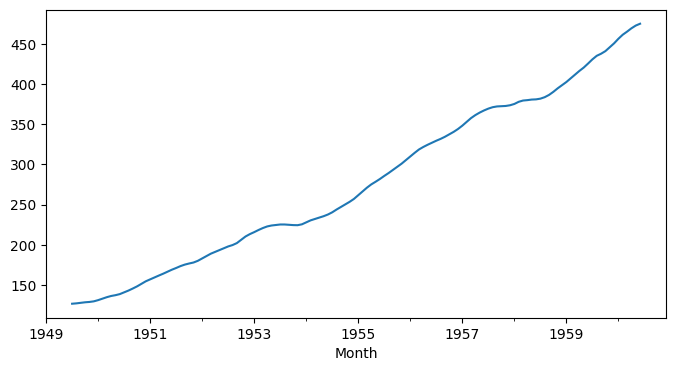

In [131]:
plt.figure(figsize=(8,4))
decomp.trend.plot()

Clearly **upward** trend

### Seasonal

<Axes: xlabel='Month'>

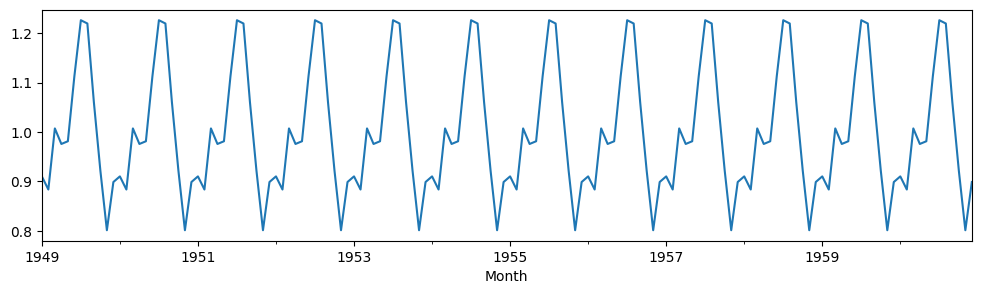

In [137]:
plt.figure(figsize=(12, 3))
decomp.seasonal.plot()

**One-year** seasonality

### Residuals

<Axes: xlabel='Month'>

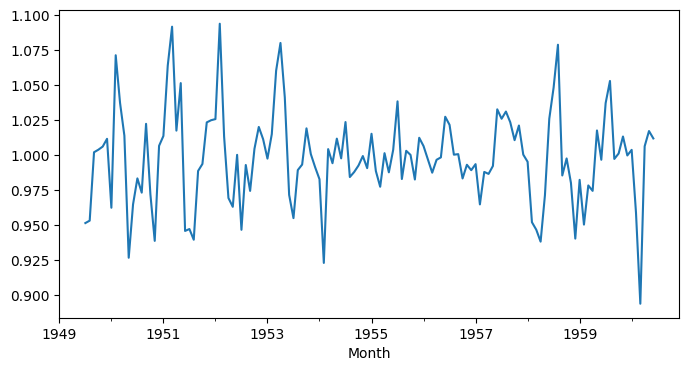

In [139]:
plt.figure(figsize=(8,4))
decomp.resid.plot()